<a href="https://colab.research.google.com/github/Akshathajogi/Akshathajogi/blob/main/Major_proj_Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/cuhkdata_augmented.zip" -d "/content/drive/MyDrive/"


In [4]:
!ls /content/drive/MyDrive/cuhkdata_augmented


testA  testB  trainA  trainB  valA  valB


In [ ]:
!pip install torch torchvision matplotlib numpy pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

Total Sketches: 120
Total Photos: 120


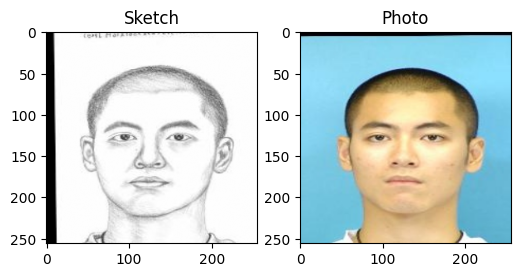

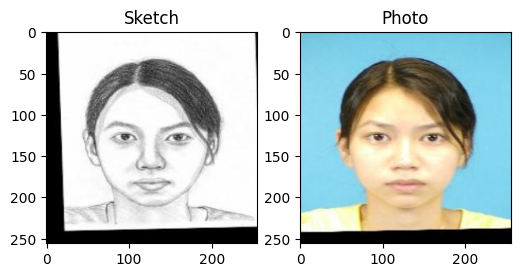

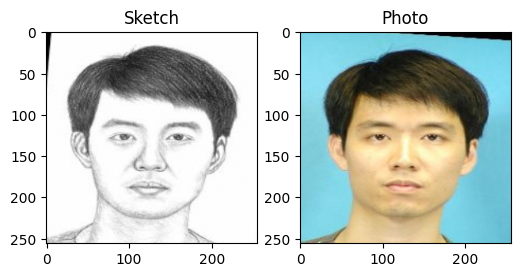

In [5]:
# Data sanity check: Visualize a few image pairs from val set

import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Paths
sketch_dir = '/content/drive/MyDrive/cuhkdata_augmented/trainB'  # Sketches
photo_dir = '/content/drive/MyDrive/cuhkdata_augmented/trainA'   # Photos

# List files
sketch_files = sorted(os.listdir(sketch_dir))
photo_files = sorted(os.listdir(photo_dir))

# Check basic info
print("Total Sketches:", len(sketch_files))
print("Total Photos:", len(photo_files))

# Display a few pairs
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

for i in range(3):
    sketch = Image.open(os.path.join(sketch_dir, sketch_files[i])).convert("L")
    photo = Image.open(os.path.join(photo_dir, photo_files[i])).convert("RGB")

    sketch = transform(sketch)
    photo = transform(photo)

    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(sketch.squeeze(), cmap='gray')
    ax[0].set_title("Sketch")
    ax[1].imshow(photo.permute(1, 2, 0))
    ax[1].set_title("Photo")
    plt.show()


In [6]:
from torch.utils.data import Dataset
from PIL import Image
import os

class SketchPhotoDataset(Dataset):
    def __init__(self, photo_dir, sketch_dir, transform_photo=None, transform_sketch=None):
        self.photo_dir = photo_dir
        self.sketch_dir = sketch_dir
        self.transform_photo = transform_photo
        self.transform_sketch = transform_sketch

        photo_files = set(os.listdir(photo_dir))
        sketch_files = set(os.listdir(sketch_dir))
        self.image_names = sorted(list(photo_files & sketch_files))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        photo_path = os.path.join(self.photo_dir, img_name)
        sketch_path = os.path.join(self.sketch_dir, img_name)

        photo = Image.open(photo_path).convert("RGB")
        sketch = Image.open(sketch_path).convert("L")  # Grayscale

        # ✅ Updated to apply Resize to 256x256 if transforms are passed
        if self.transform_photo:
            photo = self.transform_photo(photo)
        if self.transform_sketch:
            sketch = self.transform_sketch(sketch)

        return sketch, photo


In [7]:
import os

def rename_files(folder):
    files = sorted(os.listdir(folder))
    for i, filename in enumerate(files):
        ext = os.path.splitext(filename)[1]
        new_name = f"{i:04d}{ext}"  # e.g., 0001.jpg
        os.rename(os.path.join(folder, filename), os.path.join(folder, new_name))

rename_files("/content/drive/MyDrive/cuhkdata_augmented/trainA")
rename_files("/content/drive/MyDrive/cuhkdata_augmented/trainB")


In [8]:
# Paths
sketch_dir = '/content/drive/MyDrive/cuhkdata_augmented/trainB'  # Sketches
photo_dir = '/content/drive/MyDrive/cuhkdata_augmented/trainA'   # Photos

# Import necessary libraries
from torch.utils.data import DataLoader
from torchvision import transforms

transform_sketch = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_photo = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset and dataloader
train_dataset = SketchPhotoDataset(
    photo_dir=photo_dir,
    sketch_dir=sketch_dir,
    transform_photo=transform_photo,
    transform_sketch=transform_sketch
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [9]:
import torch.nn as nn

class SketchEncoder(nn.Module):
    def __init__(self):
        super(SketchEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),    # Input: [B, 3, 256, 256] → [B, 64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, 4, 2, 1),  # [B, 128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, 4, 2, 1), # [B, 256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Conv2d(256, 512, 4, 2, 1), # [B, 512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.AdaptiveAvgPool2d((1, 1))  # [B, 512, 1, 1]
        )
        self.fc = nn.Linear(512, 512)  # Output latent vector of size 512

    def forward(self, x):
        x = self.encoder(x)           # [B, 512, 1, 1]
        x = x.view(x.size(0), -1)     # Flatten: [B, 512]
        x = self.fc(x)                # Final latent representation
        return x


In [10]:
import torch.nn as nn

# RNN
class SketchRNN(nn.Module):
    def __init__(self, input_size=512, hidden_size=512):  # Changed input_size to 512
        super(SketchRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, x):
        output, _ = self.rnn(x)
        return output[:, -1, :]


In [11]:
import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self, input_dim=512):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256 * 8 * 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),    # 128x128
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),     # 256x256
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 8, 8)
        return self.decoder(x)


In [12]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),   # 128x128
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),   # 13x13 → 10x10
            nn.Sigmoid()  # Output probability
        )

    def forward(self, sketch, photo):
        x = torch.cat([sketch, photo], dim=1)  # Concatenate along channel dimension
        return self.model(x)


In [13]:
import torch
import torch.nn as nn

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models (matching your working definitions)
encoder = SketchEncoder().to(device)
rnn = SketchRNN().to(device)
generator = Generator(input_dim=512).to(device)  # Use 512 since RNN hidden_dim = 512
discriminator = Discriminator().to(device)

# Define loss functions
criterion_GAN = nn.BCEWithLogitsLoss()  # For discriminator (real/fake)
criterion_L1 = nn.L1Loss()              # For pixel-level similarity

# Optimizers (you are training encoder + RNN + generator together)
lr = 0.0002
optimizer_G = torch.optim.Adam(
    list(encoder.parameters()) + list(rnn.parameters()) + list(generator.parameters()),
    lr=lr,
    betas=(0.5, 0.999)
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [14]:
sketches_dir = "/content/drive/MyDrive/cuhkdata_augmented/trainB"  # sketches
photos_dir = "/content/drive/MyDrive/cuhkdata_augmented/trainA"     # photos


In [15]:
import os

print(os.path.exists(sketches_dir))  # Should return True if the directory exists
print(os.path.exists(photos_dir))    # Should return True if the directory exists


True
True


In [16]:
root_dir = "cuhkdata_augmented"

trainA_path = os.path.join(root_dir, "trainA")  # Sketches
trainB_path = os.path.join(root_dir, "trainB")  # Photos
valA_path   = os.path.join(root_dir, "valA")
valB_path   = os.path.join(root_dir, "valB")
testA_path  = os.path.join(root_dir, "testA")
testB_path  = os.path.join(root_dir, "testB")


In [17]:
optimizer_G = torch.optim.Adam(
    list(encoder.parameters()) +
    list(rnn.parameters()) +
    list(generator.parameters()),
    lr=0.0002, betas=(0.5, 0.999)
)


In [20]:
import os
checkpoint_path = '/content/drive/MyDrive/project_checkpoint.pth'

start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    encoder.load_state_dict(checkpoint['encoder'])
    rnn.load_state_dict(checkpoint['rnn'])
    generator.load_state_dict(checkpoint['generator'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"✅ Resumed training from epoch {start_epoch}")
else:
    print("❌ Checkpoint not found!")


❌ Checkpoint not found!


In [ ]:
import torch
import torch.nn as nn
import os

# ✅ Add this function above the training loop to save checkpoints
def save_checkpoint(epoch, encoder, rnn, generator, optimizer_G, optimizer_D, path="/content/drive/MyDrive/project_checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'encoder': encoder.state_dict(),
        'rnn': rnn.state_dict(),
        'generator': generator.state_dict(),
        'optimizer_G': optimizer_G.state_dict(),
        'optimizer_D': optimizer_D.state_dict()
    }
    torch.save(checkpoint, path)
    print(f"✅ Checkpoint saved at epoch {epoch}")

# ✅ Resume logic (load checkpoint if exists)
checkpoint_path = "/content/drive/MyDrive/project_checkpoint.pth"
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    encoder.load_state_dict(checkpoint['encoder'])
    rnn.load_state_dict(checkpoint['rnn'])
    generator.load_state_dict(checkpoint['generator'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"🔁 Resumed from epoch {start_epoch}")
else:
    print("🚀 Starting fresh training.")


# ===================== 🔁 Your original code starts from here 🔁 =====================

# Training hyperparameters
num_epochs = 20000
lambda_L1 = 10  # Weight for L1 loss

# Labels for real and fake images
real_label = 1.0
fake_label = 0.0

# Training loop
for epoch in range(start_epoch, num_epochs):
    for i, (sketch, real_photo) in enumerate(train_loader):
        sketch = sketch.to(device)           # [B, 3, 256, 256]
        real_photo = real_photo.to(device)   # [B, 3, 256, 256]
        batch_size = sketch.size(0)

        ### ========== Train Discriminator ========== ###
        discriminator.zero_grad()

        # Real pairs
        output_real = discriminator(sketch, real_photo)
        label_real = torch.full_like(output_real, real_label, device=device)
        loss_D_real = criterion_GAN(output_real, label_real)

        # Fake photo generation
        z = encoder(sketch)               # [B, 512]
        z = z.unsqueeze(1)                # [B, 1, 256]
        rnn_out = rnn(z)                  # [B, 512]
        fake_photo = generator(rnn_out)   # [B, 3, 256, 256]

        output_fake = discriminator(sketch.detach(), fake_photo.detach())
        label_fake = torch.full_like(output_fake, fake_label, device=device)
        loss_D_fake = criterion_GAN(output_fake, label_fake)

        # Combine discriminator loss
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        optimizer_D.step()

        ### ========== Train Generator, Encoder, and RNN ========== ###
        encoder.zero_grad()
        rnn.zero_grad()
        generator.zero_grad()

        # Forward again (fresh for Generator)
        z = encoder(sketch)
        z = z.unsqueeze(1)
        rnn_out = rnn(z)
        fake_photo = generator(rnn_out)

        output_fake = discriminator(sketch, fake_photo)
        label_real = torch.full_like(output_fake, real_label, device=device)
        loss_G_GAN = criterion_GAN(output_fake, label_real)

        # Ensure both tensors are the same size
        real_photo_resized = nn.functional.interpolate(real_photo, size=fake_photo.shape[2:], mode='bilinear', align_corners=False)
        loss_G_L1 = criterion_L1(fake_photo, real_photo_resized) * lambda_L1

        # Total Generator loss
        loss_G = loss_G_GAN + loss_G_L1
        loss_G.backward()
        optimizer_G.step()

        # Logging
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], "
                  f"Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}, "
                  f"Loss_G_GAN: {loss_G_GAN.item():.4f}, Loss_G_L1: {loss_G_L1.item():.4f}")

    # ✅ Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        save_checkpoint(epoch, encoder, rnn, generator, optimizer_G, optimizer_D)

# ✅ Save the trained models
torch.save(generator.state_dict(), 'generator_model.pth')
torch.save(encoder.state_dict(), 'encoder_model.pth')
torch.save(rnn.state_dict(), 'rnn_model.pth')
print("✅ All models saved (generator, encoder, rnn)")


🚀 Starting fresh training.
Epoch [1/20000], Step [0/8], Loss_D: 0.8127, Loss_G: 0.8728, Loss_G_GAN: 0.6729, Loss_G_L1: 0.1999
Epoch [2/20000], Step [0/8], Loss_D: 0.6931, Loss_G: 0.8932, Loss_G_GAN: 0.6930, Loss_G_L1: 0.2002
Epoch [3/20000], Step [0/8], Loss_D: 0.6931, Loss_G: 0.8882, Loss_G_GAN: 0.6930, Loss_G_L1: 0.1952
Epoch [4/20000], Step [0/8], Loss_D: 0.6931, Loss_G: 0.8923, Loss_G_GAN: 0.6930, Loss_G_L1: 0.1992
Epoch [5/20000], Step [0/8], Loss_D: 0.6931, Loss_G: 0.8766, Loss_G_GAN: 0.6931, Loss_G_L1: 0.1836
✅ Checkpoint saved at epoch 4
Epoch [6/20000], Step [0/8], Loss_D: 0.6931, Loss_G: 0.8970, Loss_G_GAN: 0.6931, Loss_G_L1: 0.2040
Epoch [7/20000], Step [0/8], Loss_D: 0.6931, Loss_G: 0.8930, Loss_G_GAN: 0.6931, Loss_G_L1: 0.1999
Epoch [8/20000], Step [0/8], Loss_D: 0.6931, Loss_G: 0.8970, Loss_G_GAN: 0.6931, Loss_G_L1: 0.2039
Epoch [9/20000], Step [0/8], Loss_D: 0.6931, Loss_G: 0.8910, Loss_G_GAN: 0.6931, Loss_G_L1: 0.1979
Epoch [10/20000], Step [0/8], Loss_D: 0.6931, Loss_G

In [ ]:
torch.save(generator.state_dict(), '/content/drive/MyDrive/generator_model.pth')


In [ ]:
import torch
import torch.nn as nn

class SimpleGenerator(nn.Module):
    def __init__(self):
        super(SimpleGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(512, 8 * 8 * 256),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),   # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),    # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),     # 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, 4, 2, 1),     # 128x128
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 3, 4, 2, 1),      # 256x256
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 8, 8)
        return self.decoder(x)
generator = Generator(input_dim=512)
generator.load_state_dict(torch.load("generator_model.pth"))
generator.to(device)
generator.eval()
print("✅ Loaded generator for 256x256 output.")

# ✅ Load the trained RNN (add this block)
rnn = SketchRNN().to(device)
rnn.load_state_dict(torch.load("rnn_model.pth"))
rnn.eval()
print("✅ Loaded RNN model.")
encoder = SketchEncoder().to(device)
encoder.load_state_dict(torch.load("encoder_model.pth"))
encoder.eval()
print("✅ Loaded Encoder model.")


KeyboardInterrupt: 

In [ ]:
from torchvision import transforms
from PIL import Image

# Load the sketch (don't convert to RGB here)
image = Image.open('1_B.jpg')

# Preprocessing pipeline
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Ensure sketch becomes [3, H, W]
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Apply transform
input_tensor = transform(image).unsqueeze(0)  # Shape: [1, 3, 256, 256]


FileNotFoundError: [Errno 2] No such file or directory: '1_B.jpg'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder.to(device)
generator.to(device)

input_tensor = input_tensor.to(device)

with torch.no_grad():
    latent_vector = encoder(input_tensor)         # [1, 512]
    latent_vector = latent_vector.unsqueeze(1)    # [1, 1, 512] for RNN
    rnn_output = rnn(latent_vector)               # [1, 512]
    generated_image = generator(rnn_output)       # [1, 3, 256, 256]


NameError: name 'input_tensor' is not defined

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Convert from [-1, 1] back to [0, 1] for visualization
to_pil = T.Compose([
    T.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]),
    T.ToPILImage()
])

image_out = to_pil(generated_image.squeeze(0).cpu())
plt.imshow(image_out)
plt.axis('off')
plt.title("Generated Image")
plt.show()
